In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['axes.grid'] = False

from keras.datasets import mnist
from sklearn.neural_network import BernoulliRBM
from sklearn.model_selection import train_test_split

Mount drive to import/export files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
plot_dir = "/content/drive/MyDrive/Colab Notebooks/Assignment 4/Plots/"

## Utility functions used in the notebook

In [3]:
def rbm_gibbs_sample_image(rbm, im, steps):
  assert len(im.shape) < 3
  if len(im.shape) == 2:
    rows = im.shape[0]
    cols = im.shape[1]
    im = im.reshape((-1))
  else:
    im = im.copy()
  for _ in range(steps):
    im = rbm.gibbs(im)
  if rows is not None and cols is not None:
    im = im.reshape((rows, cols))
  return im.astype('float32')
    
def image_palette(X, nr = None, m = 20):
  if nr is None:
    nr = X.shape[0]
  return np.rollaxis(np.rollaxis(X[0:nr].reshape(m, -1, 28, 28), 0, 2), 1, 3).reshape(-1, m * 28)

def remove_rows(X, start, end):
  X = X.copy()
  if len(X.shape) == 2:
    X[start:end] = 0
  elif len(X.shape) == 3:
    X[:,start:end] = 0
  return X

# About RBMs

More information can be found [in the sklearn user guide](https://scikit-learn.org/stable/modules/neural_networks_unsupervised.html#rbm).

## Load and show the mnist data

The exercise will use the MNIST dataset. We load the data and preprocess the images.

In [4]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
X_train = X_train.reshape((X_train.shape[0], -1))
X_test = X_test.reshape((X_test.shape[0],-1))
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
X_test = X_test[0:100]
# Perform a train test split to get a validation set
X_train, X_val = train_test_split(X_train, test_size=0.2, random_state=42)

11490434/11490434 [==============================] - 2s 0us/step


In [5]:
from sklearn.manifold import TSNE

In [6]:
X_train.shape

(48000, 784)

In [8]:
N = 2000
indices = np.random.choice(len(X_train), size=N, replace=False)

X = X_train[indices]
y = Y_train[indices]

In [9]:
X_embedded = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=3).fit_transform(X)

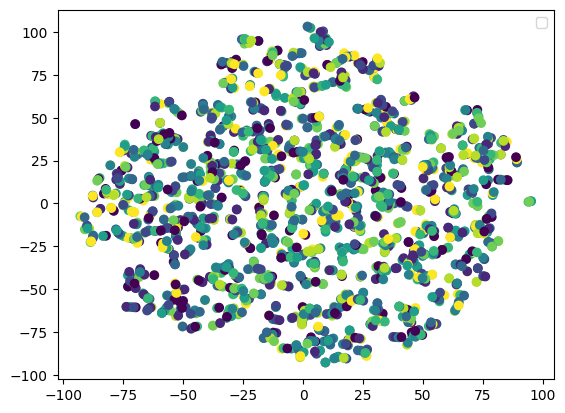

In [13]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, cmap="viridis")
plt.legend()
plt.show()

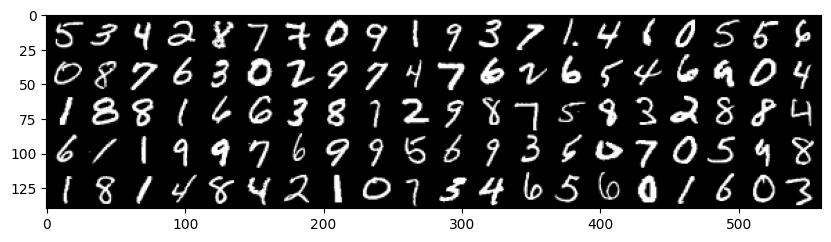

In [ ]:
flattened_images = image_palette(X_train, 100)
plt.figure(figsize=(10,20))
plt.imshow(flattened_images)
plt.show()

## Train the RBM
**Exercise** What is the effect of the different parameters: **n_components**, **learning_rate**, **n_iter**. These parameters are, respectively, the number of components, the learning rate and the number of iterations. <br/>
Evaluate the performance visually in the next code cell.


In [ ]:
# Hyperparameters:
n_components = 500
learning_rate = 0.01
n_iter = 10
rbm = BernoulliRBM(n_components=n_components, learning_rate=learning_rate, random_state=0, n_iter=n_iter, verbose=True)
rbm.fit(X_train)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -92.69, time = 29.47s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -81.58, time = 30.63s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -75.50, time = 31.04s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -72.27, time = 29.95s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -70.41, time = 30.08s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -69.32, time = 30.11s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -67.85, time = 30.30s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -65.49, time = 31.53s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -66.61, time = 30.38s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -66.13, time = 30.33s


BernoulliRBM(learning_rate=0.01, n_components=500, random_state=0, verbose=True)

In [ ]:
train_score = np.mean(rbm.score_samples(X_train))
test_score = np.mean(rbm.score_samples(X_train))

## Sample the trained RBM and show the result
The gibbs_steps variable determines how many Gibbs sampling steps will be performed for each test image i.e. with the test images as initialization. <br/>
**Exercise** Try different values and observe the result. Can you explain the result? <br/>
Compare the result with the original test images, shown one cell lower.


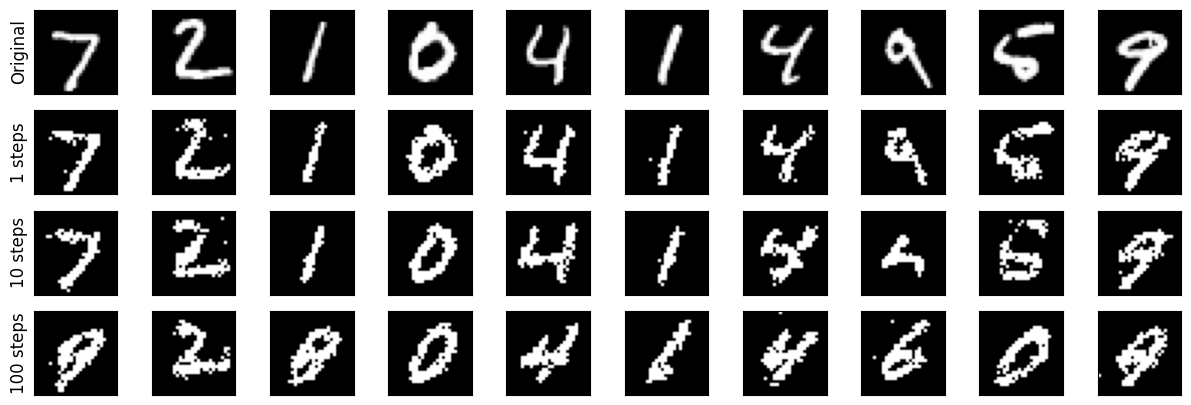

In [ ]:
# Determine number of gibbs steps
gibbs_steps_list = [0, 1, 10, 100]
# Determine data to work with
nb_images = 10
total_nb_images = len(gibbs_steps_list) * nb_images
data = X_test[:nb_images]

nrows = len(gibbs_steps_list)
ncols = nb_images
fig, axs = plt.subplots(nrows, ncols, figsize=(15,5), sharey=True, sharex=True)
for i in range(total_nb_images):
  # Get current row and col index
  row, col = i // ncols, i % ncols
  ax = axs[row, col]
  # Get the current image & number of steps to perform on this
  img = data[col].copy()
  gibbs_steps = gibbs_steps_list[row]
  for _ in range(gibbs_steps):
    img = rbm.gibbs(img)

  # Plot result here
  ax.imshow(img.reshape(28,28), cmap="Greys_r")
  ax.set_xticks([])
  ax.set_yticks([])
  if col == 0:
    if gibbs_steps == 0:
      ax.set_ylabel(f"Original", fontsize=12)
    else:
      ax.set_ylabel(f"{gibbs_steps} steps", fontsize=12)

# plt.savefig(plot_dir + "RBM_gibbs_sampling.pdf", bbox_inches = "tight")
plt.show()

In [ ]:
# plt.figure(figsize=(10,20))
# plt.imshow(image_palette(X_test))

## Reconstruction of unseen images
In this cell, we will remove pixel rows from certain images. Using the recently trained RBM, we will then try to reconstruct the original images.  <br/>
The following variables control this process: <br/>


*   **reconstruction_gibbs_steps**: The number of gibbs steps used to reconstruct the image.
*   **start_test_index**: The first index of the test set to use.
*   **nr**: the number of images starting from **start_test_index** to reconstruct.
*   **start_row_to_remove**:  The index of the first row that should be removed.
*   **end_row_to_remove**: The index up to which the rows should be removed.

**Exercise** Adjust these variables and observe the result of the reconstruction in the shown image.
What is the role of the previously seen RBM hyperparameters on the reconstruction? <br/>
How many rows can you remove such that reconstruction is still possible? <br/>
In the next code cell, the removed rows will be replaced by the reconstructed rows.




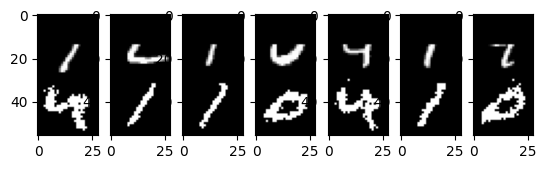

In [ ]:
reconstruction_gibbs_steps = 1000
start_test_index = 0
nr = 7
start_row_to_remove = 0
end_row_to_remove = 14
to_reconstruct = X_test[start_test_index:start_test_index + nr].reshape((-1,28,28))
to_reconstruct = remove_rows(to_reconstruct, start_row_to_remove, end_row_to_remove)
reconstructed = np.zeros(to_reconstruct.shape)
for i in range(nr):
  reconstructed[i] = rbm_gibbs_sample_image(rbm, to_reconstruct[i], reconstruction_gibbs_steps)
combined_images = np.concatenate((to_reconstruct,reconstructed), axis=1)
fig = plt.figure()
for i in range(nr): 
  ax1 = fig.add_subplot(1,nr,i+1)
  ax1.imshow(combined_images[i])

plt.show()

In [ ]:
start_row_to_remove
end_row_to_remove
to_reconstruct[:,start_row_to_remove:end_row_to_remove] = reconstructed[:,start_row_to_remove:end_row_to_remove]
fig = plt.figure()
for i in range(nr): 
  ax1 = fig.add_subplot(1,nr,i+1)
  ax1.imshow(to_reconstruct[i])

plt.show()

## Component visualisation
In the final cell, the components (weights of each neuron) of the RBM are shown.<br/> 
Observing these components (think back to CNNs) may offer insights into the trained model.

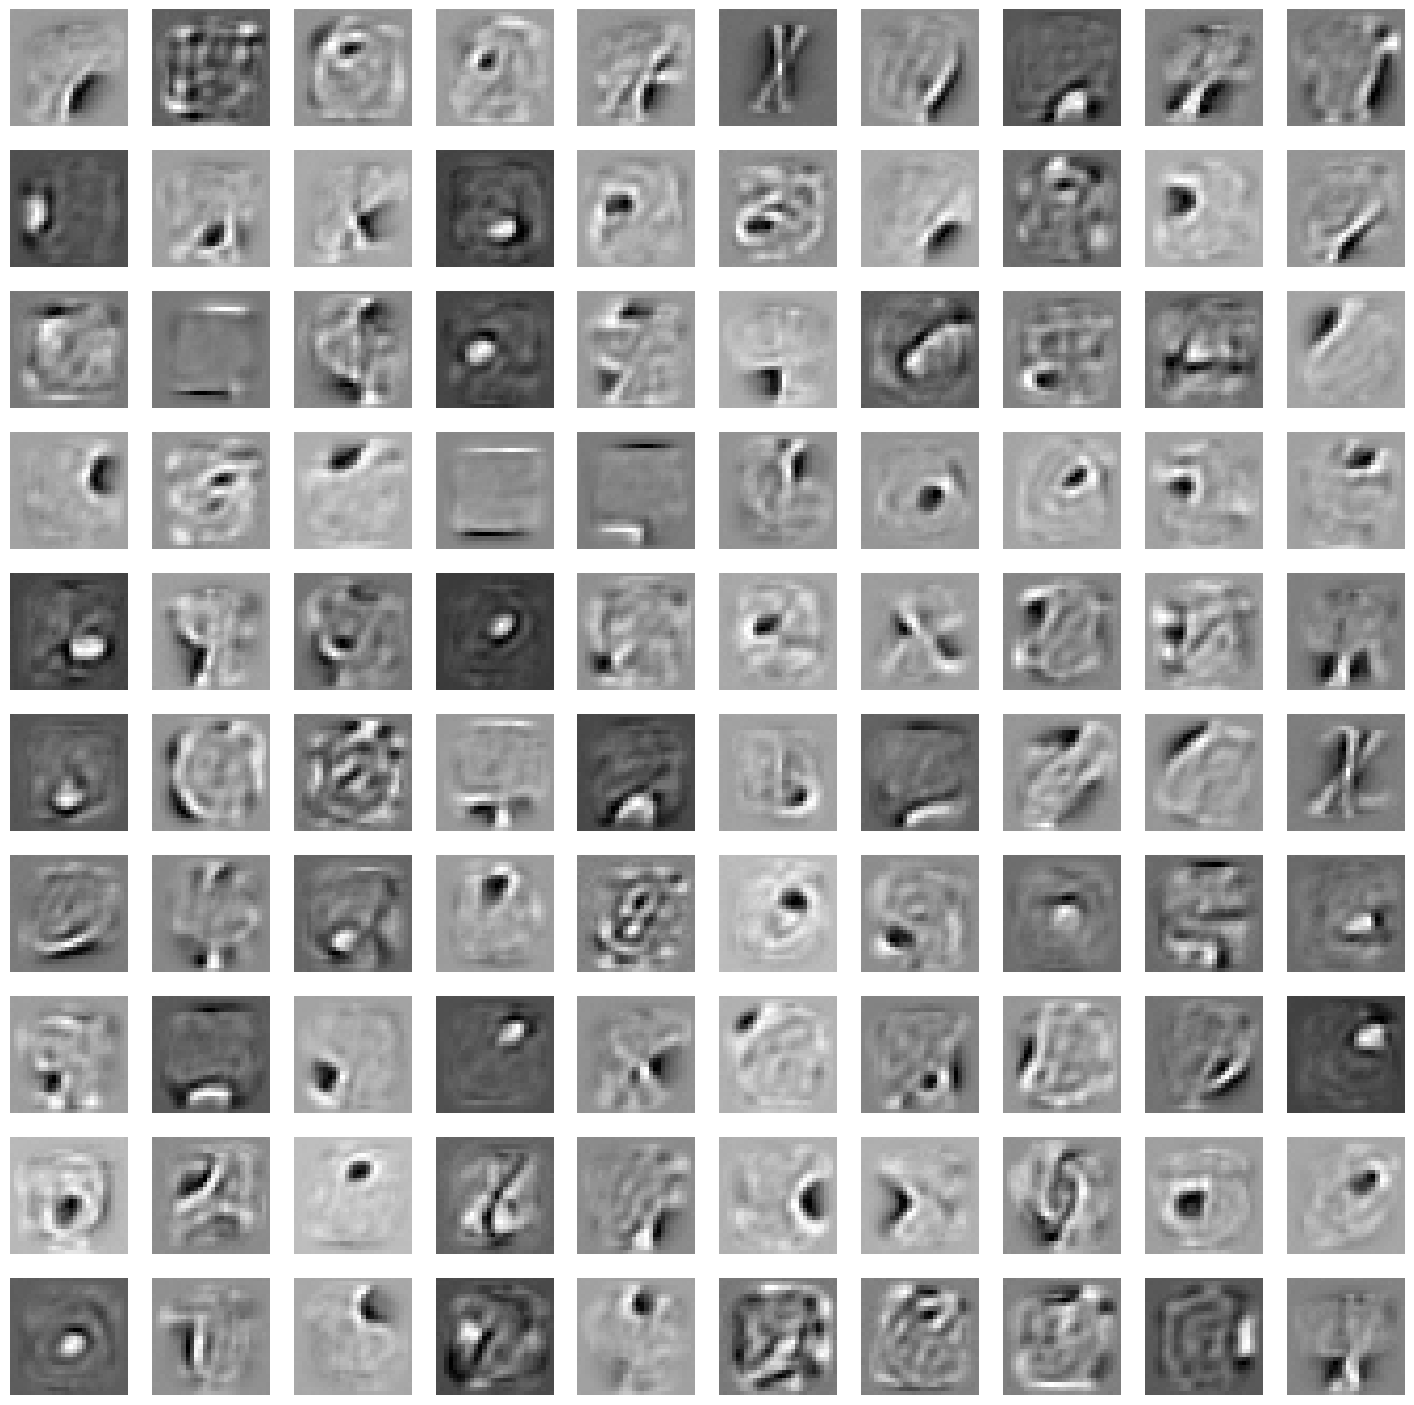

In [ ]:
plt.figure(figsize=(18, 18))
nr_components = rbm.components_.shape[0]
nr_components = 100
for i in range(nr_components):
    c = rbm.components_[i]
    plt.subplot(10, int(np.ceil(nr_components/10)), i + 1)
    plt.imshow(c.reshape((28, 28)), cmap = "gray", interpolation='nearest')
    plt.axis('off')

# plt.suptitle('Components extracted by the RBM', fontsize=16);
# plt.savefig(plot_dir + "RBM_components.pdf", bbox_inches="tight")